## XGBoost 

We use the XGBoost Python package to separate signal from background for rare radiative decays $b \rightarrow s (d) \gamma$. XGBoost is a scalable, distributed implementation of gradient tree boosting that builds the tree itself in parallel, leading to speedy cross validation (relative to other iterative algorithms). Refer to the original paper by Chen et. al: https://arxiv.org/pdf/1603.02754v1.pdf as well as the github: https://github.com/dmlc/xgboost

Author: Justin Tan - 5/04/17

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import time, os

#### Training

In [40]:
# Set training mode, hadronic channel.
mode = 'gamma_only'
channel = 'kstar0'

Load feature vectors saved as Pandas dataframe, convert to data matrix structure used by XGBoost.

In [41]:
df = pd.read_hdf('/home/ubuntu/radiative/df/kstar0/kstar0_gamma_sig_cont.h5', 'df')

In [9]:
df = pd.read_hdf('/home/ubuntu/radiative/df/rho0/std_norm_sig_cus.h5', 'df')

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training, testing sets
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df[df.columns[:-1]], df['labels'],
                                                                test_size = 0.05, random_state = 24601)

dTrain = xgb.DMatrix(data = df_X_train.values, label = df_y_train.values, feature_names = df.columns[:-1])
dTest = xgb.DMatrix(data = df_X_test.values, label = df_y_test.values, feature_names = df.columns[:-1])
# Save to XGBoost binary file for faster loading
dTrain.save_binary("dTrain" + mode + channel + ".buffer")
dTest.save_binary("dTest" + mode + channel + ".buffer")

Specify the starting hyperparameters for the boosting algorithm. Ideally this would be optimized using cross-validation. Refer to https://github.com/dmlc/xgboost/blob/master/doc/parameter.md for the full list. 
Important parameters for regularization control model complexity and add randomness to make training robust against noise.
* eta: Reduces feature weights after each boosting iteration
* subsample: Adjusts proportion of instance that XGBoost collects to grow trees
* max_depth: Maximum depth of tree structure. Larger depth $\rightarrow$ greater complexity/overfitting
* gamma: Minimum loss reduction required to further partition a leaf node on the tree

In [46]:
# Boosting hyperparameters
params = {'eta': 0.2, 'seed':0, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.05, 
             'objective': 'binary:logistic', 'max_depth':5, 'min_child_weight':1, 'silent':0}

# Specify multiple evaluation metrics for validation set
params['eval_metric'] = 'error@0.5'
pList = list(params.items())+[('eval_metric', 'auc')]

In [48]:
# Number of boosted trees to construct
nTrees = 75
# Specify validation set to watch performance
evalList  = [(dTrain,'train'), (dTest,'eval')]
evalDict = {}

print("Starting model training\n")
start_time = time.time()
# Train the model using the above parameters
bst = xgb.train(params = pList, dtrain = dTrain, evals = evalList, num_boost_round = nTrees, 
          evals_result = evalDict, early_stopping_rounds = 20)

# Save our model
model_name = mode + channel + str(nTrees) + '.model'
bst.save_model(model_name)

delta_t = time.time() - start_time
print("Training ended. Elapsed time: (%.3f s)" %(delta_t))

Starting model training

[0]	train-error:0.094659	train-auc:0.901981	eval-error:0.093589	eval-auc:0.902183
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 20 rounds.
[1]	train-error:0.089944	train-auc:0.932601	eval-error:0.089384	eval-auc:0.932535
[2]	train-error:0.079728	train-auc:0.946918	eval-error:0.078795	eval-auc:0.947209
[3]	train-error:0.079144	train-auc:0.949071	eval-error:0.078444	eval-auc:0.949497
[4]	train-error:0.078459	train-auc:0.949874	eval-error:0.077205	eval-auc:0.950388
[5]	train-error:0.077653	train-auc:0.952025	eval-error:0.076503	eval-auc:0.952759
[6]	train-error:0.075482	train-auc:0.958021	eval-error:0.074239	eval-auc:0.958771
[7]	train-error:0.071186	train-auc:0.961964	eval-error:0.069933	eval-auc:0.962892
[8]	train-error:0.072895	train-auc:0.962241	eval-error:0.071744	eval-auc:0.963223
[9]	train-error:0.071959	train-auc:0.963297	eval-error:0.070903	eval-auc:0.964307
[10]	train-err

* Crossfeed accuracy: 96%, AUC = 0.991
* Continuum accuracy: ~ 99%, AUC ~ 1
* Custom accuracy: ~

#### Optimizing Hyperparameters

The set of parameters which control the behaviour of the algorithm are not learned from the training data, called *hyperparameters*. The best value for each will depend on the dataset. We can optimize these by performing a grid search over the parameter space, using $n-$fold cross validation: The original sample is randomly partitioned into $n$ equally size subsamples - a single subsample is retained as the validation and the remaining $n-1$ subsamples are used as training data. Repeat, with each subsample used exactly once as the validation data. XGBoost is compatible with `scikit-learn`'s API, so we can reuse code from our AdaBoost notebook. See http://scikit-learn.org/stable/modules/grid_search.html

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import scipy.stats as stats

# Set number of parameter settings to be sampled
n_iter = 25

# Set parameter distributions for random search CV using the AUC metric
cv_paramDist = {'learning_rate': stats.uniform(loc = 0.05, scale = 0.15), # 'n_estimators': stats.randint(150, 300),
                'colsample_bytree': stats.uniform(0.8, 0.195),
                'subsample': stats.uniform(loc = 0.8, scale = 0.195),
                'max_depth': [3, 4, 5, 6],
                'min_child_weight': [1, 2, 3]}

fixed_params = {'n_estimators': 350, 'seed': 24601, 'objective': 'binary:logistic'}
xgb_randCV = RandomizedSearchCV(xgb.XGBClassifier(**fixed_params), cv_paramDist, scoring = 'roc_auc', cv = 5, 
                                n_iter = n_iter, verbose = 2, n_jobs = -1)

start = time.time()
xgb_randCV.fit(df_X_train.values, df_y_train.values)
print("RandomizedSearchCV complete. Time elapsed: %.2f seconds for %d candidates" % ((time.time() - start), n_iter))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] colsample_bytree=0.913962813044, learning_rate=0.140240583722, max_depth=5, min_child_weight=2, subsample=0.849028425443 
[CV] colsample_bytree=0.913962813044, learning_rate=0.140240583722, max_depth=5, min_child_weight=2, subsample=0.849028425443 
[CV] colsample_bytree=0.913962813044, learning_rate=0.140240583722, max_depth=5, min_child_weight=2, subsample=0.849028425443 
[CV] colsample_bytree=0.913962813044, learning_rate=0.140240583722, max_depth=5, min_child_weight=2, subsample=0.849028425443 
[CV]  colsample_bytree=0.913962813044, learning_rate=0.140240583722, max_depth=5, min_child_weight=2, subsample=0.849028425443, total=15.0min
[CV] colsample_bytree=0.913962813044, learning_rate=0.140240583722, max_depth=5, min_child_weight=2, subsample=0.849028425443 
[CV]  colsample_bytree=0.913962813044, learning_rate=0.140240583722, max_depth=5, min_child_weight=2, subsample=0.849028425443, total=15.8min
[CV] colsample_bytr

In [25]:
# Best set of hyperparameters
xgb_randCV.best_params_

{'colsample_bytree': 0.82779669726408012,
 'learning_rate': 0.10568674671267647,
 'max_depth': 6,
 'min_child_weight': 1,
 'subsample': 0.99190140241207247}

In [ ]:
optParams = {'eta': 0.1, 'seed':0, 'subsample': 0.95, 'colsample_bytree': 0.9, 'gamma': 0.05, 
             'objective': 'binary:logistic', 'max_depth':6, 'min_child_weight':1, 'silent':0}

In [33]:
# Cross-validation on optimal parameters
xgb_cv = xgb.cv(params = optParams, dtrain = dTrain, nfold = 5, metrics = ['error', 'auc'], verbose_eval = 10, 
                stratified = True, as_pandas = True, early_stopping_rounds = 30, num_boost_round = 500)

[0]	train-auc:0.861859+0.000278173	train-error:0.205978+0.000608732	test-auc:0.860835+0.00146269	test-error:0.207193+0.00196467
[10]	train-auc:0.897839+0.00052163	train-error:0.179376+0.000859587	test-auc:0.896055+0.00147139	test-error:0.181291+0.0016627
[20]	train-auc:0.90633+0.000345617	train-error:0.172124+0.000265181	test-auc:0.903926+0.0016062	test-error:0.174492+0.00190713
[30]	train-auc:0.910556+0.000486815	train-error:0.168388+0.000565942	test-auc:0.907547+0.00107931	test-error:0.171029+0.00167272
[40]	train-auc:0.913759+9.17322e-05	train-error:0.165542+0.000198846	test-auc:0.910145+0.00118215	test-error:0.168821+0.00146569
[50]	train-auc:0.916147+0.000203117	train-error:0.163324+0.000250475	test-auc:0.911946+0.00116153	test-error:0.167316+0.00156567
[60]	train-auc:0.91799+0.000224505	train-error:0.161606+0.00043436	test-auc:0.913203+0.00112846	test-error:0.16619+0.00176853
[70]	train-auc:0.91963+0.000194173	train-error:0.159949+0.000354578	test-auc:0.914253+0.00102195	test-err

Model performance varies dramatically depending on our choice of hyperparameters. Tuning a large number of hyperparameters a grid search may be prohibitively expensive and we can instead randomly sample from distributions of hyperparamters and evaluate the model at these points.

#### Inference

In [50]:
def plot_ROC_curve(y_true, network_output, meta):
    """
    Plots the receiver-operating characteristic curve
    Inputs: y:                 One-hot encoded binary labels
            network_output:    NN output probabilities
    Output: AUC:               Area under the ROC Curve

    """
    from sklearn.metrics import roc_curve, auc
    
    # Compute ROC curve, integrate
    fpr, tpr, thresholds = roc_curve(y_true, network_output)    
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.axes([.1,.1,.8,.7])                           
    plt.figtext(.5,.9, r'$\mathrm{Receiver \;operating \;characteristic}$', fontsize=15, ha='center')
    plt.figtext(.5,.85, meta, fontsize=10,ha='center')
    plt.plot(fpr, tpr, color='darkorange',
                     lw=2, label='ROC curve - custom (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1.0, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel(r'$\mathrm{False \;Positive \;Rate}$')
    plt.ylabel(r'$\mathrm{True \;Positive \;Rate}$')
    plt.legend(loc="lower right")
    plt.savefig("graphs/" + "clf_ROCcurve.pdf",format='pdf', dpi=1000)
    plt.show()
    plt.gcf().clear()

In [51]:
# Load previously trained model
xgb_pred = bst.predict(dTest)
meta = 'XGBoost - max_depth: 5, subsample: 0.9, $\eta = 0.2$'

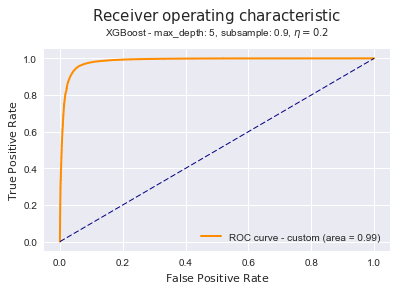

In [52]:
plot_ROC_curve(df_y_test.values, xgb_pred, meta)


#### Feature Importances

Plot the feature importances of the 20 features that contributed the most to overall tree impurity reduction.

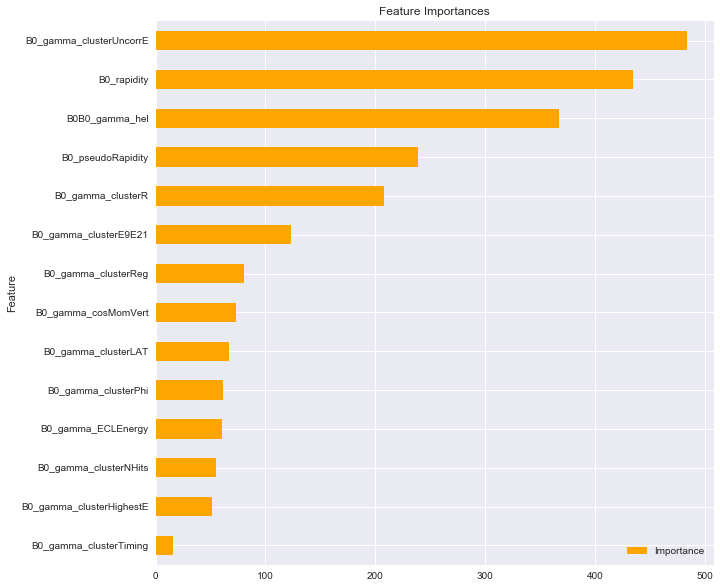

In [49]:
%matplotlib inline
importances = bst.get_fscore()
df_importance = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
df_importance.sort_values(by = 'Importance', inplace = True)
df_importance[-20:].plot(kind = 'barh', x = 'Feature', color = 'orange', figsize = (10,10), 
                         title = 'Feature Importances')